In [1]:
import os
import sys
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader
from iblatlas.regions import BrainRegions

from sklearn import linear_model as sklm
from sklearn.metrics import accuracy_score, balanced_accuracy_score, r2_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from behavior_models.utils import format_data as format_data_mut
from behavior_models.utils import format_input as format_input_mut

from brainwidemap.bwm_loading import load_good_units, load_all_units, load_trials_and_mask, merge_probes
from brainwidemap.decoding.functions.process_targets import load_behavior
from brainwidemap.decoding.settings_for_BWM_figure.settings_choice import params
from brainwidemap.decoding.settings_for_BWM_figure.settings_choice import RESULTS_DIR

from brainwidemap.decoding.functions.balancedweightings import balanced_weighting
from brainwidemap.decoding.functions.process_inputs import (
    build_predictor_matrix,
    select_ephys_regions,
    preprocess_ephys
)
from brainwidemap.decoding.functions.process_targets import (
    compute_beh_target,
    compute_target_mask,
    transform_data_for_decoding,
    logisticreg_criteria,
    get_target_data_per_trial_wrapper,
    check_bhv_fit_exists,
    optimal_Bayesian
)
from brainwidemap.decoding.functions.utils import save_region_results, get_save_path
from brainwidemap.decoding.functions.nulldistributions import generate_null_distribution_session
from brainwidemap.decoding.functions.decoding import decode_cv

/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [2]:
def reduced_rank_close_form(X_c, Y_c, R, penalty):
    
    K, T, C = X_c.shape
    
    # compute U
    S_t = np.einsum("ktc,kdn->ctdn", X_c, X_c)
    
    I = np.eye(C*T)
    np.fill_diagonal(I, penalty)
    I = I.reshape(C, T, T, C)
    S_t = S_t + I
    
    D = np.eye(C*T)
    np.fill_diagonal(D, 1/np.diag(S_t.reshape(C*T, T*C)))
    D = np.sqrt(D).reshape(C,T,T,C)
    D[np.isnan(D)] = np.nanmean(D)

    XY = (X_c.T @ Y_c).reshape(C,T)
                     
    U, _, _ = np.linalg.svd(XY)
    U = U[:,:R]
    
    # compute V
    G_part = np.einsum("cr, ctdn->rtdn", U, S_t)
    G = np.einsum("rtdn, ns->rs", G_part, U)
    H = U.T @ (X_c.T @ Y_c).squeeze()
    V = np.linalg.inv(G) @ H
    
    return U, V

### load data

In [3]:
roi = "VISa"

In [4]:
print(params['target'])
params['behfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'behavioral')
params['behfit_path'].mkdir(parents=True, exist_ok=True)
params['neuralfit_path'] = RESULTS_DIR.joinpath('decoding', 'results', 'neural')
params['neuralfit_path'].mkdir(parents=True, exist_ok=True)
params['add_to_saving_path'] = (f"_binsize={1000 * params['binsize']}_lags={params['n_bins_lag']}_"
                                f"mergedProbes_{params['merged_probes']}")
imposter_file = RESULTS_DIR.joinpath('decoding', f"imposterSessions_{params['target']}.pqt")
bwm_session_file = RESULTS_DIR.joinpath('decoding', 'bwm_cache_sessions.pqt')
print(params["align_time"])
params["time_window"] = (-0.5, 1.5)
print(params["time_window"])
params["binsize"] = 0.05
print(params["binsize"])
params['n_pseudo'] = 0
params['n_runs'] = 1

one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')
bwm_df = pd.read_parquet(bwm_session_file)

pids_per_region = one.search_insertions(atlas_acronym=[roi], query_type='remote')
print(len(pids_per_region))

bwm_df = bwm_df.loc[bwm_df.pid.isin(pids_per_region)]
unit_type = "all_units"
dir_path = Path("/home/yizi/decode-brain-wide-map/results")/roi


choice
stimOn_times
(-0.5, 1.5)
0.05
79


1 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d


/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/one/api.py:296: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  self._cache[table].loc[records.index[to_update], :] = records[to_update]
/home/yizi/anaconda3/envs/ibl_bwm/lib/python3.10/site-packages/one/api.py:296: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

error loading choice data

Working on eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 8



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:04<00:18,  4.54s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:09<00:14,  4.71s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:14<00:09,  4.96s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:19<00:04,  4.80s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.504 auc:  0.611
reduced-rank acc:  0.530 auc:  0.595


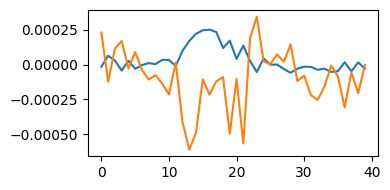

/home/yizi/decode-brain-wide-map/results/VISa/6713a4a7-faed-4df2-acab-ee4e63326f8d/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 6713a4a7-faed-4df2-acab-ee4e63326f8d
[0.5039098473275898, 0.6110444992277324, 0.5298493774861085, 0.5951156006085275]
2 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 56956777-dca5-468c-87cb-78150432cc57
error loading choice data

Working on eid: 56956777-dca5-468c-87cb-78150432cc57


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 14



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:02<00:09,  2.33s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:05<00:08,  2.94s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:08<00:05,  2.78s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:10<00:02,  2.43s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.572 auc:  0.665
reduced-rank acc:  0.620 auc:  0.659


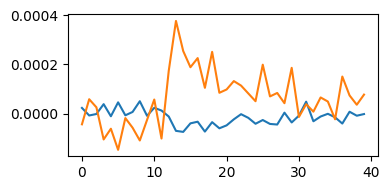

/home/yizi/decode-brain-wide-map/results/VISa/56956777-dca5-468c-87cb-78150432cc57/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 56956777-dca5-468c-87cb-78150432cc57
[0.5716141139892386, 0.6651171289909722, 0.6201467692341216, 0.6591439946043194]
3 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: a8a8af78-16de-4841-ab07-fde4b5281a03
error loading choice data

Working on eid: a8a8af78-16de-4841-ab07-fde4b5281a03


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 72



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:09<00:38,  9.74s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:18<00:27,  9.28s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:28<00:18,  9.40s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:37<00:09,  9.23s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.686 auc:  0.755
reduced-rank acc:  0.670 auc:  0.758


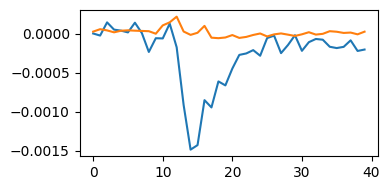

/home/yizi/decode-brain-wide-map/results/VISa/a8a8af78-16de-4841-ab07-fde4b5281a03/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: a8a8af78-16de-4841-ab07-fde4b5281a03
[0.6862594066557002, 0.7551363223976102, 0.6702510855409323, 0.7580695294989044]
4 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 6ed57216-498d-48a6-b48b-a243a34710ea
error loading choice data

Working on eid: 6ed57216-498d-48a6-b48b-a243a34710ea


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 51



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:09<00:36,  9.06s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:18<00:27,  9.19s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:26<00:17,  8.74s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:36<00:09,  9.19s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.739 auc:  0.815
reduced-rank acc:  0.664 auc:  0.720


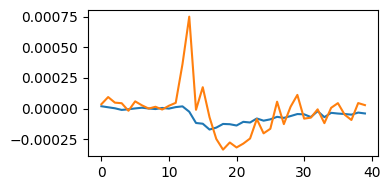

/home/yizi/decode-brain-wide-map/results/VISa/6ed57216-498d-48a6-b48b-a243a34710ea/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 6ed57216-498d-48a6-b48b-a243a34710ea
[0.7387120843032172, 0.814664442700157, 0.66439432324654, 0.7199838863927533]
5 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
error loading choice data

Working on eid: 51e53aff-1d5d-4182-a684-aba783d50ae5


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 51



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:07<00:30,  7.51s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:13<00:20,  6.90s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:21<00:14,  7.39s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:28<00:07,  7.11s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.798 auc:  0.876
reduced-rank acc:  0.689 auc:  0.767


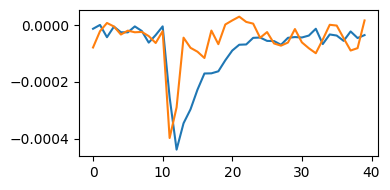

/home/yizi/decode-brain-wide-map/results/VISa/51e53aff-1d5d-4182-a684-aba783d50ae5/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 51e53aff-1d5d-4182-a684-aba783d50ae5
[0.7980349468115172, 0.8760468756894388, 0.6888772850970267, 0.7666644231547928]
6 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
error loading choice data

Working on eid: 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 68



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:15<01:03, 15.88s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:32<00:48, 16.03s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:48<00:32, 16.32s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [01:05<00:16, 16.44s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.613 auc:  0.709
reduced-rank acc:  0.579 auc:  0.650


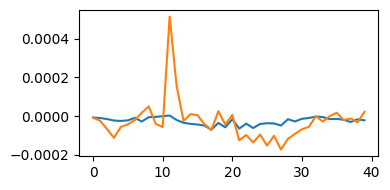

/home/yizi/decode-brain-wide-map/results/VISa/4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b
[0.613243980449419, 0.7092322542307153, 0.5791860155973059, 0.6504383294750152]
7 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: c99d53e6-c317-4c53-99ba-070b26673ac4
error loading choice data

Working on eid: c99d53e6-c317-4c53-99ba-070b26673ac4


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 141



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:29<01:58, 29.75s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:57<01:26, 28.75s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [01:28<00:58, 29.46s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [01:57<00:29, 29.48s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.776 auc:  0.858
reduced-rank acc:  0.725 auc:  0.785


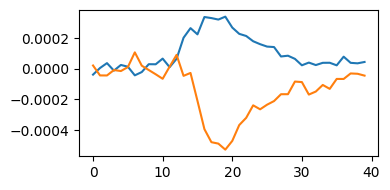

/home/yizi/decode-brain-wide-map/results/VISa/c99d53e6-c317-4c53-99ba-070b26673ac4/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: c99d53e6-c317-4c53-99ba-070b26673ac4
[0.7761045887538958, 0.8578979911857333, 0.7246317100955298, 0.7852322980043022]
8 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: ecb5520d-1358-434c-95ec-93687ecd1396
error loading choice data

Working on eid: ecb5520d-1358-434c-95ec-93687ecd1396


VISa
9 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 4b00df29-3769-43be-bb40-128b1cba6d35


error loading choice data

VISa not found. Skip to next eid.
10 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: f312aaec-3b6f-44b3-86b4-3a0c119c0438
error loading choice data

Working on eid: f312aaec-3b6f-44b3-86b4-3a0c119c0438


VISa
11 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 824cf03d-4012-4ab1-b499-c83a92c5589e


error loading choice data

Working on eid: 824cf03d-4012-4ab1-b499-c83a92c5589e


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 24



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:03<00:14,  3.70s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:07<00:11,  3.96s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.16s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [00:16<00:04,  4.00s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.725 auc:  0.862
reduced-rank acc:  0.729 auc:  0.837


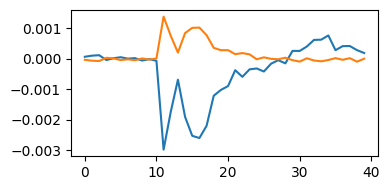

/home/yizi/decode-brain-wide-map/results/VISa/824cf03d-4012-4ab1-b499-c83a92c5589e/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 824cf03d-4012-4ab1-b499-c83a92c5589e
[0.7253391165802038, 0.8616409440114102, 0.728688433980164, 0.8366540342778542]
12 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: e2b845a1-e313-4a08-bc61-a5f662ed295e
error loading choice data

Working on eid: e2b845a1-e313-4a08-bc61-a5f662ed295e
2024-01-02 21:33:15.814 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2024-01-02 21:33:15.815 INFO     [base_models.py:  119]   with adaptive MCMC...
2024-01-02 21:33:15.816 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:00<08:43,  8.60it/s]

2024-01-02 21:34:16.239 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:12<08:43,  8.41it/s]

2024-01-02 21:34:28.231 INFO     [base_models.py:  189]   acceptance is 0.3020833333333333


 14%|█████▌                                  | 700/5000 [01:24<08:26,  8.49it/s]

2024-01-02 21:34:40.189 INFO     [base_models.py:  189]   acceptance is 0.2875


 16%|██████▍                                 | 800/5000 [01:36<08:15,  8.48it/s]

2024-01-02 21:34:52.168 INFO     [base_models.py:  189]   acceptance is 0.2796875


 18%|███████▏                                | 900/5000 [01:48<08:26,  8.10it/s]

2024-01-02 21:35:04.495 INFO     [base_models.py:  189]   acceptance is 0.27749999999999997


 20%|███████▊                               | 1000/5000 [02:00<08:29,  7.85it/s]

2024-01-02 21:35:16.660 INFO     [base_models.py:  189]   acceptance is 0.27375000000000005


 20%|███████▊                               | 1001/5000 [02:00<08:24,  7.92it/s]

2024-01-02 21:35:16.781 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.02345986 1.03614637 0.99896613 1.00598375]


2024-01-02 21:35:16.785 INFO     [base_models.py:  194]   final posterior_mean is [0.23943007 0.14023087 0.08556136 0.12980136]
2024-01-02 21:35:16.786 INFO     [base_models.py:  203]   acceptance ratio is of 0.273976023976024. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2024-01-02 21:35:16.789 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA036/model_actKernel_single_zeta/train_e2b845a1.pkl


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 126



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:16<01:05, 16.32s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:34<00:52, 17.58s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [00:51<00:34, 17.27s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [01:09<00:17, 17.59s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.548 auc:  0.613
reduced-rank acc:  0.579 auc:  0.596


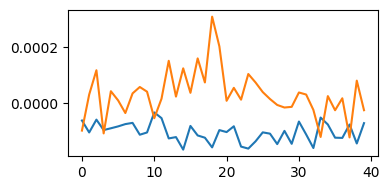

/home/yizi/decode-brain-wide-map/results/VISa/e2b845a1-e313-4a08-bc61-a5f662ed295e/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: e2b845a1-e313-4a08-bc61-a5f662ed295e
[0.5479794053464266, 0.6131466293818748, 0.5792838581644866, 0.5956604002789091]
13 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 2bdf206a-820f-402f-920a-9e86cd5388a4
error loading choice data

Working on eid: 2bdf206a-820f-402f-920a-9e86cd5388a4
2024-01-02 21:37:10.152 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2024-01-02 21:37:10.153 INFO     [base_models.py:  119]   with adaptive MCMC...
2024-01-02 21:37:10.154 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:13<11:07,  6.74it/s]

2024-01-02 21:38:23.619 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [01:27<10:24,  7.04it/s]

2024-01-02 21:38:38.437 INFO     [base_models.py:  189]   acceptance is 0.2504166666666667


 14%|█████▌                                  | 700/5000 [01:42<10:33,  6.79it/s]

2024-01-02 21:38:52.943 INFO     [base_models.py:  189]   acceptance is 0.24428571428571427


 16%|██████▍                                 | 800/5000 [01:57<10:04,  6.95it/s]

2024-01-02 21:39:07.480 INFO     [base_models.py:  189]   acceptance is 0.2415625


 18%|███████▏                                | 900/5000 [02:11<09:50,  6.94it/s]

2024-01-02 21:39:22.042 INFO     [base_models.py:  189]   acceptance is 0.24055555555555555


 20%|███████▊                               | 1000/5000 [02:26<10:14,  6.51it/s]

2024-01-02 21:39:36.668 INFO     [base_models.py:  189]   acceptance is 0.2375


 20%|███████▊                               | 1001/5000 [02:26<10:06,  6.59it/s]

2024-01-02 21:39:36.823 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.03310233 1.04030121 1.04473037 1.00429859]


2024-01-02 21:39:36.825 INFO     [base_models.py:  194]   final posterior_mean is [0.23362447 0.11524757 0.12075675 0.03219401]
2024-01-02 21:39:36.827 INFO     [base_models.py:  203]   acceptance ratio is of 0.2375124875124875. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2024-01-02 21:39:36.830 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/UCLA037/model_actKernel_single_zeta/train_2bdf206a.pkl


VISa
14 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: aad23144-0e52-4eac-80c5-c4ee2decb198


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.16c81eaf-a032-49cd-9823-09c0c7350fd2.npy Bytes: 5256


100%|█████████| 0.00501251220703125/0.00501251220703125 [00:00<00:00,  2.44it/s]

error loading choice data



Working on eid: aad23144-0e52-4eac-80c5-c4ee2decb198
2024-01-02 21:39:46.045 INFO     [base_models.py:  109]   Launching MCMC procedure with 4 chains, 5000 max steps and [0.05 0.04 0.02 0.02] std_RW. Early stopping is activated
2024-01-02 21:39:46.046 INFO     [base_models.py:  119]   with adaptive MCMC...
2024-01-02 21:39:46.046 INFO     [base_models.py:  121]   initial point for MCMC is [[0.5    0.5    0.25   0.25  ]
 [0.75   0.25   0.375  0.125 ]
 [0.25   0.75   0.125  0.375 ]
 [0.375  0.375  0.3125 0.0625]]


 10%|████                                    | 500/5000 [01:38<14:55,  5.03it/s]

2024-01-02 21:41:25.067 INFO     [base_models.py:  165]   Adaptive MCMC starting...


 12%|████▊                                   | 600/5000 [02:00<16:50,  4.35it/s]

2024-01-02 21:41:46.859 INFO     [base_models.py:  189]   acceptance is 0.18208333333333332


 14%|█████▌                                  | 700/5000 [02:21<14:48,  4.84it/s]

2024-01-02 21:42:08.019 INFO     [base_models.py:  189]   acceptance is 0.18000000000000002


 16%|██████▍                                 | 800/5000 [02:42<14:06,  4.96it/s]

2024-01-02 21:42:28.435 INFO     [base_models.py:  189]   acceptance is 0.1878125


 18%|███████▏                                | 900/5000 [03:02<13:55,  4.91it/s]

2024-01-02 21:42:48.470 INFO     [base_models.py:  189]   acceptance is 0.1913888888888889


 20%|███████▊                               | 1000/5000 [03:23<10:30,  6.34it/s]

2024-01-02 21:43:09.913 INFO     [base_models.py:  189]   acceptance is 0.19274999999999998


 20%|███████▊                               | 1001/5000 [03:23<11:32,  5.77it/s]

2024-01-02 21:43:10.103 INFO     [base_models.py:  159]   Early stopping criteria was validated at step 1001. R values are: [1.01977794 1.03109128 1.03668113 1.05796906]


2024-01-02 21:43:10.105 INFO     [base_models.py:  194]   final posterior_mean is [0.1682249  0.08360146 0.03204085 0.01887107]
2024-01-02 21:43:10.106 INFO     [base_models.py:  203]   acceptance ratio is of 0.1928071928071928. Careful, this ratio should be close to 0.234. If not, change the standard deviation of the random walk
2024-01-02 21:43:10.109 INFO     [base_models.py:  312]   results of inference SAVED in /mnt/3TB/yizi/decode-paper-brain-wide-map/decoding/results/behavioral/KS023/model_actKernel_single_zeta/train_aad23144.pkl


VISa
15 / 16 ...
truncated job because this job_repeat (0) includes more than 0 pseudo sessions
Running merged probes for session eid: 781b35fd-e1f0-4d14-b2bb-95b7263082bb


error loading choice data

Working on eid: 781b35fd-e1f0-4d14-b2bb-95b7263082bb


Region:   0%|                                             | 0/1 [00:00<?, ?it/s]

VISa
# units: 111



  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 20%|█████████                                    | 1/5 [00:22<01:28, 22.18s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 40%|██████████████████                           | 2/5 [00:46<01:09, 23.32s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 60%|███████████████████████████                  | 3/5 [01:08<00:45, 22.59s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(D).reshape(C,T,T,C)

 80%|████████████████████████████████████         | 4/5 [01:34<00:24, 24.09s/it]/tmp/ipykernel_41749/2536621855.py:15: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(

baseline acc:  0.767 auc:  0.823
reduced-rank acc:  0.696 auc:  0.750


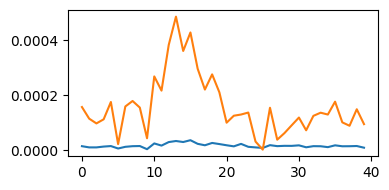

/home/yizi/decode-brain-wide-map/results/VISa/781b35fd-e1f0-4d14-b2bb-95b7263082bb/stimOn_times_-0.5_1.5_0.05_all_units.npy
Finished eid: 781b35fd-e1f0-4d14-b2bb-95b7263082bb
[0.7665868562755541, 0.8232641456199208, 0.6955370429805765, 0.7501919401386677]


In [5]:
n_sess = bwm_df.shape[0] if bwm_df.shape[0] <= 15 else 15
for idx in range(n_sess):
    
    res_by_eids = {}
    
    print(f"{idx+1} / {n_sess+1} ...")
    
    job_repeat = 0 
    pseudo_ids = np.arange(job_repeat * params['n_pseudo_per_job'], (job_repeat + 1) * params['n_pseudo_per_job']) + 1
    if 1 in pseudo_ids:
        pseudo_ids = np.concatenate((-np.ones(1), pseudo_ids)).astype('int64')
    if pseudo_ids[0] > params['n_pseudo']:
        print(f"ended job because this job_repeat ({job_repeat}) does not include any pseudo sessions < {params['n_pseudo']}")
        exit()
    if pseudo_ids[-1] > params['n_pseudo']:
        print(f"truncated job because this job_repeat ({job_repeat}) includes more than {params['n_pseudo']} pseudo sessions")
        pseudo_ids = pseudo_ids[pseudo_ids <= params['n_pseudo']]

    if params['merged_probes']:
        eid = bwm_df['eid'].unique()[idx]
        tmp_df = bwm_df.set_index(['eid', 'subject']).xs(eid, level='eid')
        subject = tmp_df.index[0]
        pids = tmp_df['pid'].to_list()  # Select all probes of this session
        probe_names = tmp_df['probe_name'].to_list()
        print(f"Running merged probes for session eid: {eid}")
    else:
        eid = bwm_df.iloc[idx]['eid']
        subject = bwm_df.iloc[idx]['subject']
        pid = bwm_df.iloc[idx]['pid']
        probe_name = bwm_df.iloc[idx]['probe_name']
        print(f"Running probe pid: {pid}")

    sess_loader = SessionLoader(one, eid)
    sess_loader.load_trials()

    trials_df, trials_mask = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_minrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=params['max_rt'],
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_without_maxrt = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=params['min_rt'], max_rt=None,
        min_trial_len=params['min_len'], max_trial_len=params['max_len'],
        exclude_nochoice=True, exclude_unbiased=params['exclude_unbiased_trials'])
    _, trials_mask_withonly_nochoice = load_trials_and_mask(
        one=one, eid=eid, sess_loader=sess_loader, min_rt=None, max_rt=None,
        min_trial_len=None, max_trial_len=None,
        exclude_nochoice=True, exclude_unbiased=False)

    params['trials_mask_diagnostics'] = [trials_mask,
                                         trials_mask_without_minrt,
                                         trials_mask_without_maxrt,
                                         trials_mask_withonly_nochoice]

    # if params['target'] in ['wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
    if params['target'] in ['choice', 'wheel-vel', 'wheel-speed', 'l-whisker-me', 'r-whisker-me']:
        # load target data
        dlc_dict = load_behavior(params['target'], sess_loader)
        # load imposter sessions
        params['imposter_df'] = pd.read_parquet(imposter_file) if params['n_pseudo'] > 0 else None
    else:
        dlc_dict = None
        params['imposter_df'] = None

    if params['merged_probes']:
        clusters_list = []
        spikes_list = []
        for pid, probe_name in zip(pids, probe_names):
            # tmp_spikes, tmp_clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
            tmp_spikes, tmp_clusters = load_all_units(one, pid, eid=eid, pname=probe_name)
            tmp_clusters['pid'] = pid
            spikes_list.append(tmp_spikes)
            clusters_list.append(tmp_clusters)
        spikes, clusters = merge_probes(spikes_list, clusters_list)
    else:
        # spikes, clusters = load_good_units(one, pid, eid=eid, pname=probe_name)
        spikes, clusters = load_all_units(one, pid, eid=eid, pname=probe_name)

    neural_dict = {
        'spk_times': spikes['times'],
        'spk_clu': spikes['clusters'],
        'clu_regions': clusters['acronym'],
        'clu_qc': {k: np.asarray(v) for k, v in clusters.to_dict('list').items()},
        'clu_df': clusters
    }

    metadata = {
        'subject': subject,
        'eid': eid,
        'probe_name': probe_name
    }
    
    kwargs = params
    kwargs['n_runs'] = 1
    kwargs['n_bins_lag'] = 0
    
    # select brain regions from beryl atlas to loop over
    brainreg = BrainRegions()
    beryl_reg = brainreg.acronym2acronym(neural_dict['clu_regions'], mapping='Beryl')
    regions = (
        [[k] for k in np.unique(beryl_reg)] if kwargs['single_region'] else [np.unique(beryl_reg)])
    
    if [roi] not in regions:
        print(f"{roi} not found. Skip to next eid.")
        continue
    
    print(f'Working on eid: {metadata["eid"]}')
    filenames = []  # this will contain paths to saved decoding results for this eid

    # kwargs['use_imposter_session'] = True # turn on for bin_size > 1
    kwargs['use_imposter_session'] = False
    if kwargs['use_imposter_session'] and not kwargs['stitching_for_imposter_session']:
        trials_df = trials_df[:int(kwargs['max_number_trials_when_no_stitching_for_imposter_session'])]

    if 0 in pseudo_ids:
        raise ValueError(
            'pseudo id can be -1 (actual session) or strictly greater than 0 (pseudo session)')

    if not np.all(np.sort(pseudo_ids) == pseudo_ids):
        raise ValueError('pseudo_ids must be sorted')

    if kwargs['model'] == optimal_Bayesian and np.any(trials_df.probabilityLeft.values[:90] != 0.5):
        raise ValueError(
            'The optimal Bayesian model assumes 90 unbiased trials at the beginning of the '
            'session, which is not the case here.')

    # check if is trained
    eids_train = (
        [metadata['eid']] if 'eids_train' not in metadata.keys() else metadata['eids_train'])
    if 'eids_train' not in metadata.keys():
        metadata['eids_train'] = eids_train
    elif metadata['eids_train'] != eids_train:
        raise ValueError(
            'eids_train are not supported yet. If you do not understand this error, '
            'just take out the eids_train key in the metadata to solve it')

    if isinstance(kwargs['model'], str):
        import pickle
        from braindelphi.params import INTER_INDIVIDUAL_PATH
        inter_individual = pickle.load(open(INTER_INDIVIDUAL_PATH.joinpath(kwargs['model']), 'rb'))
        if metadata['eid'] not in inter_individual.keys():
            logging.exception('no inter individual model found')
            print(filenames)
        inter_indiv_model_specifications = inter_individual[metadata['eid']]
        print('winning interindividual model is %s' % inter_indiv_model_specifications['model_name'])
        if inter_indiv_model_specifications['model_name'] not in kwargs['modeldispatcher'].values():
            logging.exception('winning inter individual model is LeftKernel or RightKernel')
            print(filenames)
        kwargs['model'] = {v: k for k, v in kwargs['modeldispatcher'].items()}[inter_indiv_model_specifications['model_name']]
        kwargs['model_parameters'] = inter_indiv_model_specifications['model_parameters']
    else:
        kwargs['model_parameters'] = None
        # train model if not trained already
        if kwargs['model'] != optimal_Bayesian and kwargs['model'] is not None:
            side, stim, act, _ = format_data_mut(trials_df)
            stimuli, actions, stim_side = format_input_mut([stim], [act], [side])
            behmodel = kwargs['model'](
                kwargs['behfit_path'], np.array(metadata['eids_train']), metadata['subject'],
                actions, stimuli, trials_df, stim_side, single_zeta=True)
            istrained, _ = check_bhv_fit_exists(
                metadata['subject'], kwargs['model'], metadata['eids_train'],
                kwargs['behfit_path'], modeldispatcher=kwargs['modeldispatcher'], single_zeta=True)
            if not istrained:
                behmodel.load_or_train(remove_old=False)

    if kwargs['balanced_weight'] and kwargs['balanced_continuous_target']:
        raise NotImplementedError("see tag `decoding_biasCWnull` for a previous implementation.")
    else:
        target_distribution = None

    # get target values
    if kwargs['target'] in ['pLeft', 'signcont', 'strengthcont', 'choice', 'feedback']:
        target_vals_list, target_vals_to_mask = compute_beh_target(
            trials_df, metadata, return_raw=True, **kwargs)
        target_mask = compute_target_mask(
            target_vals_to_mask, kwargs['exclude_trials_within_values'])

    else:
        if dlc_dict is None or dlc_dict['times'] is None or dlc_dict['values'] is None:
            raise ValueError('dlc_dict does not contain any data')
        _, target_vals_list, target_mask = get_target_data_per_trial_wrapper(
            target_times=dlc_dict['times'],
            target_vals=dlc_dict['values'],
            trials_df=trials_df,
            align_event=kwargs['align_time'],
            align_interval=kwargs['time_window'],
            binsize=kwargs['binsize'])

    mask = trials_mask & target_mask

    if sum(mask) <= kwargs['min_behav_trials']:
        msg = 'session contains %i trials, below the threshold of %i' % (
            sum(mask), kwargs['min_behav_trials'])
        logging.exception(msg)
        print(filenames)
        
    roi_idx = np.argwhere(np.array([region[0].find(roi) for region in regions]) == 0).astype(int)
    regions = regions[roi_idx[0][0]]
    for region in tqdm(regions, desc='Region: ', leave=False):
        
        print(regions[0])
        # pull spikes from this region out of the neural data
        reg_clu_ids = select_ephys_regions(neural_dict, beryl_reg, region, **kwargs)

        # skip region if there are not enough units
        n_units = len(reg_clu_ids)
        if n_units < 3:
            continue
        elif n_units > 150:
            continue
        print(f"# units: {n_units}")

        # bin spikes from this region for each trial
        msub_binned, cl_inds_used = preprocess_ephys(reg_clu_ids, neural_dict, trials_df, **kwargs)
        cl_uuids_used = list(neural_dict['clu_df'].iloc[cl_inds_used]['uuids'])

        # make design matrix
        bins_per_trial = msub_binned[0].shape[0]
        Xs = (
            msub_binned if bins_per_trial == 1
            else [build_predictor_matrix(s, kwargs['n_bins_lag']) for s in msub_binned]
        )
        
        # reduced rank model
        X = np.array(Xs)
        Y = np.array(target_vals_list)
        Y_c = (Y - Y.mean()).reshape(-1,1)
        X_c = X - X.mean()
        
        n_folds = 5
        penalty = [1e-4, 1e-3, 1e-2, 1, 1e1, 1e2, 1e3, 1e4]

        baseline_accs, baseline_aucs = [], []
        rrr_accs, rrr_aucs = [], []
        Us, Vs = [], []

        skf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
        for train, test in tqdm(skf.split(X, Y), total=n_folds):

            K,T,C = X.shape

            X_train, X_test, Y_train, Y_test = X[train], X[test], Y[train], Y[test]
            decoder = GridSearchCV(sklm.LogisticRegression(max_iter=10000), {"C": penalty})
            decoder.fit(X_train.reshape((-1,T*C)), Y_train)
            yhat = decoder.predict(X_test.reshape((-1,T*C)))
            prob = decoder.predict_proba(X_test.reshape((-1,T*C)))[:,1]
            acc = balanced_accuracy_score(Y_test, yhat)
            auc = roc_auc_score(Y_test, prob)
            baseline_accs.append(acc)
            baseline_aucs.append(auc)

            X_train, X_test, Y_train, Y_test = X_c[train], X_c[test], Y_c[train], Y_c[test]
            U, V = reduced_rank_close_form(X_train, Y_train, R=2, penalty=0)
            Y_train, Y_test = Y[train], Y[test]
            Yhat_train = np.einsum("ktr,rt->k", X_train @ U, V)
            Yhat_test = np.einsum("ktr,rt->k", X_test @ U, V)

            decoder = GridSearchCV(sklm.LogisticRegression(max_iter=10000), {"C": penalty})
            decoder.fit(Yhat_train.reshape(-1,1), Y_train)
            Yhat = decoder.predict(Yhat_test.reshape(-1,1))

            acc = balanced_accuracy_score(Y_test, Yhat)
            auc = roc_auc_score(Y_test, Yhat_test)
            rrr_accs.append(acc)
            rrr_aucs.append(auc)
            Us.append(U)
            Vs.append(V)

        print(f"baseline acc: {np.mean(baseline_accs): .3f} auc: {np.mean(baseline_aucs): .3f}")
        print(f"reduced-rank acc: {np.mean(rrr_accs): .3f} auc: {np.mean(rrr_aucs): .3f}")

        Us = np.array(Us).mean(0)
        Vs = np.array(Vs).mean(0).T

        plt.figure(figsize=(4,2))
        plt.plot(Vs)
        plt.tight_layout()
        plt.show()
        
        if not os.path.exists(dir_path/eid):
            os.makedirs(dir_path/eid)
        
        res_path = dir_path/eid/f'{params["align_time"]}_{params["time_window"][0]}_{params["time_window"][1]}_{params["binsize"]}_{unit_type}.npy'
        print(res_path)
            
        res = []
        for filename in filenames:
            with open(filename, 'rb') as f:
                res.append(pickle.load(f))

        res_by_eids.update({eid: {}})
        res_by_eids[eid].update({"metrics": [np.mean(baseline_accs), np.mean(baseline_aucs), np.mean(rrr_accs), np.mean(rrr_aucs)]})            
        res_by_eids[eid].update({"UV": [Us, Vs]})            

        print(f'Finished eid: {metadata["eid"]}')
        print(res_by_eids[eid]["metrics"])
        np.save(res_path, res_by_eids)